# F20AA Coursework 2 - Amazon Review Dataset

#

## **Installing Packages**

In [2]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 6.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1f0dc0cbd85007b727319e346c06161360f73c059aa12039fe3b636c0aefd531
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


## **Importing Libraries**

In [62]:
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import nltk
# nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
# import spacy
# !python -m spacy download en_core_web_sm
# nlp = spacy.load('en_core_web_sm')
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk import ngrams

import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn import model_selection
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading Data**

In [5]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
link = "https://drive.google.com/file/d/1_vv4gk3ztKD2TrYSnf9h9FGVvsOX1HJF/view?usp=sharing"
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('train.csv')
df_train = pd.read_csv('train.csv')

In [7]:
link = "https://drive.google.com/file/d/1CSOLMVkMOW1pv4bJr6rfv_0pq7LtR_pb/view?usp=sharing"
# to get the id part of the file
id = link.split("/")[-2]
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('test.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
# df_train = pd.read_csv("C:/Users/laksh/Downloads/F20AA CW2/train.csv")

In [ ]:
# df_test = pd.read_csv("C:/Users/laksh/Downloads/F20AA CW2/test.csv")

In [8]:
df_train.head()

,Score,Review_text
0,5,I received this product early from the seller!...
1,5,*****<br />Numi's Collection Assortment Melang...
2,5,"I was very careful not to overcook this pasta,..."
3,5,Buying this multi-pack I was misled by the pic...
4,5,These bars are so good! I loved them warmed up...


In [9]:
df_test.head()

,Review_text
0,This is a good tasting K-cup from a guy who dr...
1,these are a wonderful light crunchy breadstick...
2,Love this product! And has anyone mentioned th...
3,I just bought this and have used it around the...
4,great product. actually we've used it all now...


In [10]:
#Creating function to Clean the Text
def clean_reviews(text):
    #removing any '@' mentions
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    #removing hashtags
    text = re.sub(r'#','', text)
    #removing 'http' links
    text = re.sub(r'https?:\/\/\S+', '', text)
    #removing '\n' characters
    text = text.replace('\n', '')
    #remove html tags
    text = re.sub('<.*?>', '', text)
    #removing other unncessary special characters 
    text = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', text)
    text = text.lower()
    return text

In [11]:
#Applying the function to our extracted tweets
df_train['Review_text'] = df_train['Review_text'].apply(clean_reviews)
df_train.head(10)

,Score,Review_text
0,5,i received this product early from the seller ...
1,5,numis collection assortment melange includes5 ...
2,5,i was very careful not to overcook this pasta ...
3,5,buying this multipack i was misled by the pict...
4,5,these bars are so good i loved them warmed up ...
5,5,i love these chips i buy the 24 pack once a mo...
6,5,im a huge fan of eating cereal for breakfast i...
7,2,i was really disappointed with the sorghum we ...
8,3,a friend who has gone to korea gave me a coupl...
9,4,no need for plastic baggies or sloppy tin foil...


## **Data Visualization**

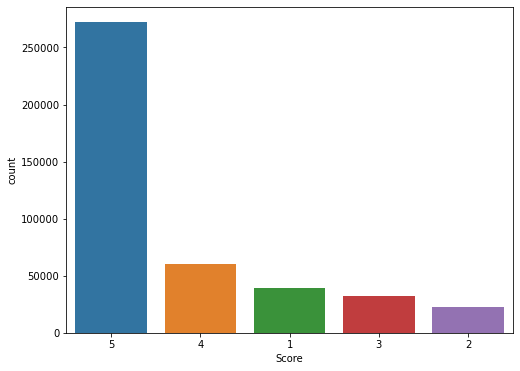

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data= df_train, x='Score', order= df_train['Score'].value_counts().index)
plt.show()

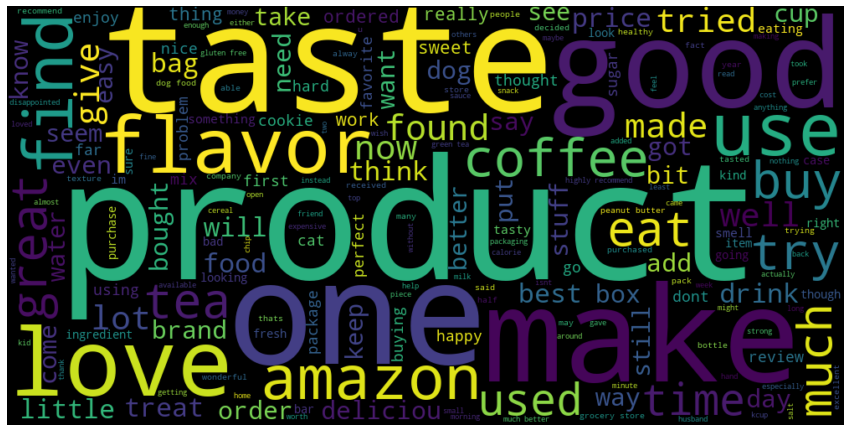

In [ ]:
#Plotting WordCloud for all the text
plt.figure(figsize=(15,15))
allWords = ''.join([words for words in df_train['Review_text']])
wordCloud = WordCloud(background_color = 'black', width = 1000, height = 500, random_state = 21, max_font_size = 200).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [13]:
def getReview(score):
      if score <= 2:
        return 'Bad'
      elif score == 3:
        return 'Neutral'
      else:
        return 'Good'

df_train['Review_level'] = df_train['Score'].apply(getReview)
df_train

,Score,Review_text,CharNumber,WordsNumber,Review_level
0,5,i received this product early from the seller ...,200,37,Good
1,5,numis collection assortment melange includes5 ...,1764,294,Good
2,5,i was very careful not to overcook this pasta ...,1082,200,Good
3,5,buying this multipack i was misled by the pict...,193,34,Good
4,5,these bars are so good i loved them warmed up ...,155,29,Good
...,...,...,...,...,...
426335,5,i had been buying at a store but they had a ha...,848,164,Good
426336,5,so glad that there are companies that are maki...,322,55,Good
426337,4,i love real scottish haggis and this brand tho...,461,91,Good
426338,5,we eat a lot of syrup in our house my three y...,580,115,Good


In [42]:
sortDF = df_train.sort_values(by=['Score'], ascending = False)
sortDF.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,...",received product early seller tastey great mid...,receiv product earli seller tastey great midda...
252681,5,kind bars are not only all natural but gluten ...,743,142,Good,"[kind, bars, are, not, only, all, natural, but...",kind bars natural gluten free well great tasti...,kind bar natur gluten free well great tast sna...
252706,5,this dark roast fine ground coffee is deliciou...,625,102,Good,"[this, dark, roast, fine, ground, coffee, is, ...",dark roast fine ground coffee delicious smells...,dark roast fine grind coffe delici smell great...
252705,5,i love the taste of this coffee the flavor is ...,182,39,Good,"[i, love, the, taste, of, this, coffee, the, f...",love taste coffee flavor good dont even put su...,love tast coffe flavor good dont even put suga...
252704,5,when you are 80 years old you know when someth...,394,74,Good,"[when, you, are, 80, years, old, you, know, wh...",80 years old know something taste incredibly g...,80 year old know someth tast incred good rich ...


In [43]:
goodDF = sortDF.loc[df_train['Review_level'] == 'Good']
goodDF.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,...",received product early seller tastey great mid...,receiv product earli seller tastey great midda...
252681,5,kind bars are not only all natural but gluten ...,743,142,Good,"[kind, bars, are, not, only, all, natural, but...",kind bars natural gluten free well great tasti...,kind bar natur gluten free well great tast sna...
252706,5,this dark roast fine ground coffee is deliciou...,625,102,Good,"[this, dark, roast, fine, ground, coffee, is, ...",dark roast fine ground coffee delicious smells...,dark roast fine grind coffe delici smell great...
252705,5,i love the taste of this coffee the flavor is ...,182,39,Good,"[i, love, the, taste, of, this, coffee, the, f...",love taste coffee flavor good dont even put su...,love tast coffe flavor good dont even put suga...
252704,5,when you are 80 years old you know when someth...,394,74,Good,"[when, you, are, 80, years, old, you, know, wh...",80 years old know something taste incredibly g...,80 year old know someth tast incred good rich ...


In [44]:
badDF = sortDF.loc[df_train['Review_level'] == 'Bad']
badDF.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
398958,2,this appeared to me to be an ideal productprov...,651,116,Bad,"[this, appeared, to, me, to, be, an, ideal, pr...",appeared ideal productproviding little bit fru...,appear ideal productprovid littl bite fruit fl...
218698,2,a slightly bitter metallic after tastea long w...,177,31,Bad,"[a, slightly, bitter, metallic, after, tastea,...",slightly bitter metallic tastea long way prope...,slight bitter metal tastea long way proper pre...
166933,2,i thought i was buying regular hot cider cups ...,390,76,Bad,"[i, thought, i, was, buying, regular, hot, cid...",thought buying regular hot cider cups walmart ...,think buy regular hot cider cup walmart get ho...
222345,2,my son loves the purees in the pouches except ...,143,32,Bad,"[my, son, loves, the, purees, in, the, pouches...",son loves purees pouches except one way tart t...,son love pure pouch except one way tart take o...
166118,2,i got some of these in a variety pack and i th...,167,35,Bad,"[i, got, some, of, these, in, a, variety, pack...",got variety pack think end throwing away taste...,get varieti pack think end throw away tast bit...


In [45]:
neutralDF = sortDF.loc[df_train['Review_level'] == 'Neutral']
neutralDF.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
27390,3,i have counted and no joke have over the past ...,323,65,Neutral,"[i, have, counted, and, no, joke, have, over, ...",counted joke past 4 years purchased 18 busy bu...,count joke past 4 year purchas 18 busi buddi t...
138808,3,as i write this review im looking at 3 large b...,1404,268,Neutral,"[as, i, write, this, review, im, looking, at, ...",write review im looking 3 large boxes popchips...,write review im look 3 larg box popchip stack ...
375396,3,i got this wasabi soy flavor a few weeks ago t...,472,101,Neutral,"[i, got, this, wasabi, soy, flavor, a, few, we...",got wasabi soy flavor weeks ago tastes right l...,get wasabi soy flavor week ago tast right last...
208692,3,i have been using it along with other scoopabl...,243,47,Neutral,"[i, have, been, using, it, along, with, other,...",using along scoopable litter together decided ...,use along scoopabl litter togeth decid track m...
124168,3,i drank this tea during the last part of my pr...,297,56,Neutral,"[i, drank, this, tea, during, the, last, part,...",drank tea last part pregnancy uterine health c...,drink tea last part pregnanc uterin health can...


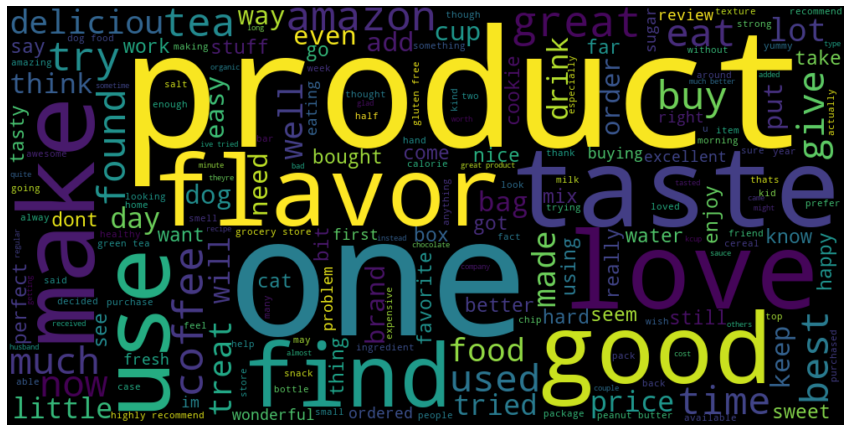

In [ ]:
plt.figure(figsize=(15,15))
goodWords = ''.join([words for words in goodDF['Review_text']])
wordCloud = WordCloud(background_color = 'black', width = 1000, height = 500, random_state = 21, max_font_size = 200).generate(goodWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

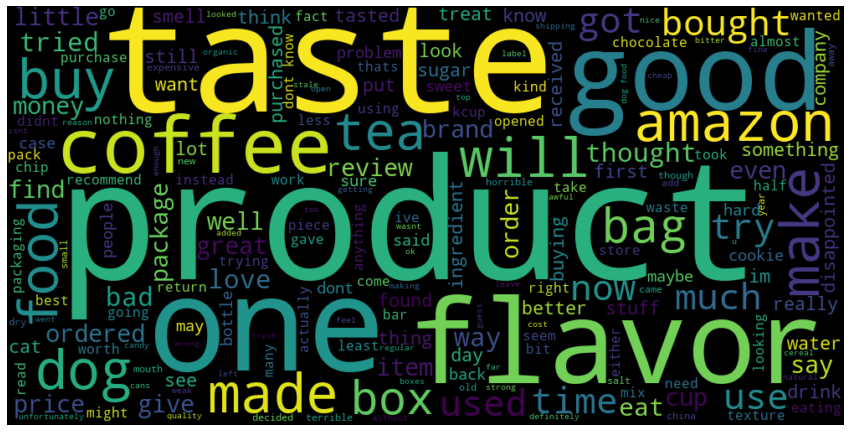

In [ ]:
#Plotting WordCloud for positive analysis
plt.figure(figsize=(15,15))
badWords = ''.join([words for words in badDF['Review_text']])
wordCloud = WordCloud(background_color = 'black', width = 1000, height = 500, random_state = 21, max_font_size = 200).generate(badWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

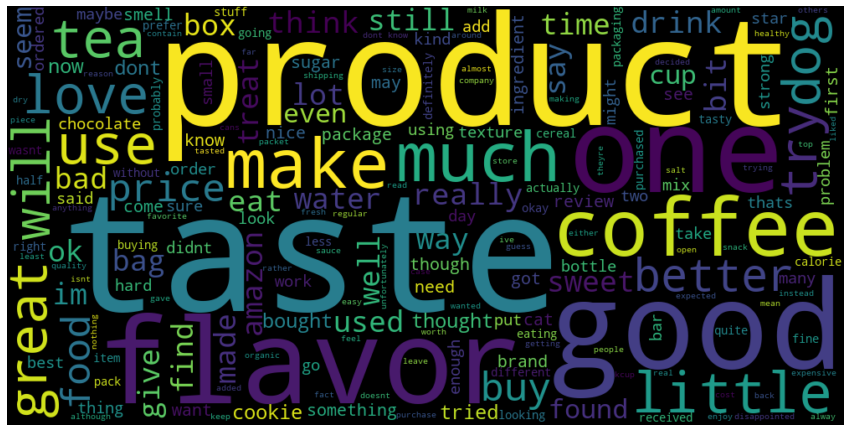

In [ ]:
#Plotting WordCloud for positive analysis
plt.figure(figsize=(15,15))
neutralWords = ''.join([words for words in neutralDF['Review_text']])
wordCloud = WordCloud(background_color = 'black', width = 1000, height = 500, random_state = 21, max_font_size = 200).generate(neutralWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [12]:
#Calculating the number of characters and words in each tweet for frequency plot.
df_train['CharNumber'] = df_train.Review_text.apply(len)  
df_train['WordsNumber'] = df_train.Review_text.apply(lambda sent: len(sent.split())) 
df_train.head()

,Score,Review_text,CharNumber,WordsNumber
0,5,i received this product early from the seller ...,200,37
1,5,numis collection assortment melange includes5 ...,1764,294
2,5,i was very careful not to overcook this pasta ...,1082,200
3,5,buying this multipack i was misled by the pict...,193,34
4,5,these bars are so good i loved them warmed up ...,155,29


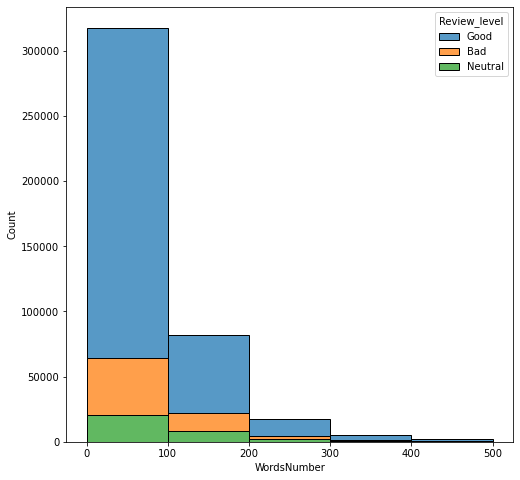

In [ ]:
#Plotting histogram for the frequency of each word with respect to each sentiment.
plt.figure(figsize=(8,8))
sns.histplot(data = df_train , x='WordsNumber',
             hue='Review_level', multiple='stack' , binrange = (0,500), binwidth = 100 )
plt.show()

## **Text Processing and Normalization**

In [14]:
def text_tokenization(text):
    #Tokenization
    tokens = []
    tokens = word_tokenize(text)
    return tokens
df_train['Tokenized_text'] = df_train['Review_text'].apply(text_tokenization)
df_train.head(10)

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,..."
1,5,numis collection assortment melange includes5 ...,1764,294,Good,"[numis, collection, assortment, melange, inclu..."
2,5,i was very careful not to overcook this pasta ...,1082,200,Good,"[i, was, very, careful, not, to, overcook, thi..."
3,5,buying this multipack i was misled by the pict...,193,34,Good,"[buying, this, multipack, i, was, misled, by, ..."
4,5,these bars are so good i loved them warmed up ...,155,29,Good,"[these, bars, are, so, good, i, loved, them, w..."
5,5,i love these chips i buy the 24 pack once a mo...,270,53,Good,"[i, love, these, chips, i, buy, the, 24, pack,..."
6,5,im a huge fan of eating cereal for breakfast i...,598,127,Good,"[im, a, huge, fan, of, eating, cereal, for, br..."
7,2,i was really disappointed with the sorghum we ...,290,51,Bad,"[i, was, really, disappointed, with, the, sorg..."
8,3,a friend who has gone to korea gave me a coupl...,536,109,Neutral,"[a, friend, who, has, gone, to, korea, gave, m..."
9,4,no need for plastic baggies or sloppy tin foil...,344,64,Good,"[no, need, for, plastic, baggies, or, sloppy, ..."


In [15]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text_tokenization(text)
    return " ".join([word for word in tokens if word not in stop_words])

df_train["Without_stopwords"] = df_train["Review_text"].apply(remove_stopwords)
df_train.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,...",received product early seller tastey great mid...
1,5,numis collection assortment melange includes5 ...,1764,294,Good,"[numis, collection, assortment, melange, inclu...",numis collection assortment melange includes5 ...
2,5,i was very careful not to overcook this pasta ...,1082,200,Good,"[i, was, very, careful, not, to, overcook, thi...",careful overcook pasta making sure take bite e...
3,5,buying this multipack i was misled by the pict...,193,34,Good,"[buying, this, multipack, i, was, misled, by, ...",buying multipack misled picture whole hazel nu...
4,5,these bars are so good i loved them warmed up ...,155,29,Good,"[these, bars, are, so, good, i, loved, them, w...",bars good loved warmed definitely think great ...


In [16]:
#Creating a function to perform text processing techniques such as: Stemming, and Lemmatization
def normalization(text):
    filtert = remove_stopwords(text)
    #Stemming
    stem = SnowballStemmer(language='english')
    stoken = []
    stoken = word_tokenize(filtert)
    stemt = ' '.join(stem.stem(i) for i in stoken)
    #Lemmatization
    lem = WordNetLemmatizer()
    sttoken = []
    sttoken = word_tokenize(stemt)
    lemt = ' '.join(lem.lemmatize(i,'v') for i in sttoken)
    return lemt

In [17]:
#Applying text processing techniques on the tweets
df_train['Normalized_text'] = df_train['Without_stopwords'].apply(normalization)
df_train.head()

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,...",received product early seller tastey great mid...,receiv product earli seller tastey great midda...
1,5,numis collection assortment melange includes5 ...,1764,294,Good,"[numis, collection, assortment, melange, inclu...",numis collection assortment melange includes5 ...,numi collect assort melang includes5 herbal te...
2,5,i was very careful not to overcook this pasta ...,1082,200,Good,"[i, was, very, careful, not, to, overcook, thi...",careful overcook pasta making sure take bite e...,care overcook pasta make sure take bite everi ...
3,5,buying this multipack i was misled by the pict...,193,34,Good,"[buying, this, multipack, i, was, misled, by, ...",buying multipack misled picture whole hazel nu...,buy multipack misl pictur whole hazel nut anot...
4,5,these bars are so good i loved them warmed up ...,155,29,Good,"[these, bars, are, so, good, i, loved, them, w...",bars good loved warmed definitely think great ...,bar good love warm definit think great snack b...


## **TF-IDF Vectorization**

## **Unigrams**

In [18]:
# Defining the vector
vector = TfidfVectorizer(sublinear_tf=True)

# Fitting the data into the vector      
X = vector.fit_transform(df_train['Normalized_text']) 

In [ ]:
test = vector.transform(df_test['Review_text'])

In [19]:
print(X)

  (0, 100459)	0.09913787848143812
  (0, 202049)	0.24359327528091854
  (0, 157928)	0.14185705660007344
  (0, 95045)	0.20035961950251147
  (0, 94168)	0.17921955607422008
  (0, 99735)	0.4624965427050426
  (0, 194765)	0.2518013640973187
  (0, 199900)	0.17223039349419167
  (0, 139838)	0.3939039218807637
  (0, 102566)	0.10057095161293929
  (0, 215804)	0.37165899281146003
  (0, 192848)	0.2591187882018386
  (0, 76830)	0.29347117895404756
  (0, 174351)	0.1906244147667277
  (0, 180586)	0.1961272272165726
  (1, 215823)	0.04069935620640281
  (1, 181041)	0.034594368272193865
  (1, 152489)	0.12747833458804428
  (1, 172215)	0.10594842263702309
  (1, 202754)	0.05798892042035944
  (1, 32370)	0.03316643771269473
  (1, 88423)	0.028026455709506383
  (1, 60860)	0.03804697367927842
  (1, 221179)	0.0322086735817714
  (1, 238346)	0.03646069422416429
  :	:
  (426338, 173004)	0.0892913240763721
  (426338, 237734)	0.10961486635508211
  (426338, 212738)	0.10344510611895857
  (426338, 100459)	0.06348231846231765
 

In [20]:
X.shape

(426340, 248414)

In [21]:
Y = df_train['Score']

In [22]:
#Splitting data into training and testing sets (70:30)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
Y_pred = LR.predict(X_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.7527794717830839


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.69      0.70      0.70      7770
           2       0.47      0.27      0.34      4495
           3       0.51      0.33      0.40      6319
           4       0.54      0.26      0.35     11998
           5       0.81      0.96      0.87     54686

    accuracy                           0.75     85268
   macro avg       0.60      0.50      0.53     85268
weighted avg       0.72      0.75      0.72     85268



In [ ]:
Y_pred1 = LR.predict(test)

In [ ]:
print(Y_pred1)

[5 5 5 ... 5 5 5]


In [ ]:
id = np.array(range(1,142115))

In [ ]:
pred_score = pd.DataFrame({'ID': id, 'Score': Y_pred1}, columns=['ID', 'Score'])
pred_score

,ID,Score
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5
...,...,...
142109,142110,5
142110,142111,5
142111,142112,5
142112,142113,5


In [ ]:
# pred_score.to_csv (r'testscores.csv', index = False, header=True)

### Bernoulli Naive Bayes

In [ ]:
BNB = BernoulliNB()
BNB.fit(X_train, Y_train)

BernoulliNB()

In [ ]:
Y_pred = BNB.predict(X_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.6651616081062063


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.63      0.42      0.51      7770
           2       0.54      0.06      0.10      4495
           3       0.37      0.16      0.22      6319
           4       0.36      0.28      0.31     11998
           5       0.72      0.89      0.80     54686

    accuracy                           0.67     85268
   macro avg       0.52      0.36      0.39     85268
weighted avg       0.63      0.67      0.62     85268



### Multinomial Naive Bayes

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [ ]:
Y_pred = MNB.predict(X_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.6438992353520664


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.90      0.02      0.05      7770
           2       0.71      0.00      0.00      4495
           3       0.89      0.00      0.00      6319
           4       0.61      0.00      0.01     11998
           5       0.64      1.00      0.78     54686

    accuracy                           0.64     85268
   macro avg       0.75      0.21      0.17     85268
weighted avg       0.68      0.64      0.51     85268



### Support Vector Machine

In [ ]:
linear_svc = LinearSVC()
svm_clf = linear_svc.fit(X_train, Y_train)

In [ ]:
Y_pred = linear_svc.predict(X_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.7835061218745603


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.72      0.76      0.74      7770
           2       0.64      0.33      0.44      4495
           3       0.63      0.40      0.49      6319
           4       0.61      0.36      0.45     11998
           5       0.83      0.96      0.89     54686

    accuracy                           0.78     85268
   macro avg       0.68      0.56      0.60     85268
weighted avg       0.76      0.78      0.76     85268



In [ ]:
# Y_pred1 = linear_svc.predict(test)

In [ ]:
# print(Y_pred1)

In [ ]:
# id1 = np.array(range(1,142115))

In [ ]:
# svcpred_score = pd.DataFrame({'ID': id1, 'Score': Y_pred1}, columns=['ID', 'Score'])
# svcpred_score

In [ ]:
# svcpred_score.to_csv (r'testscores.csv', index = False, header=True)

## **Bigrams**

In [ ]:
# Defining the vector
vector1 = TfidfVectorizer(sublinear_tf=True, ngram_range = (2,2))

# Fitting the data into the vector      
X1 = vector1.fit_transform(df_train['Normalized_text']) 

In [ ]:
test1 = vector1.transform(df_test['Review_text'])

In [ ]:
print(X1)

  (0, 2648390)	0.2419999159340375
  (0, 2246615)	0.24574069977676172
  (0, 2021453)	0.1590969377827622
  (0, 1186198)	0.2364919492400336
  (0, 1172678)	0.254867355195214
  (0, 1250303)	0.254867355195214
  (0, 2540630)	0.3004288418449102
  (0, 2620466)	0.2795145543047698
  (0, 1805309)	0.23470682126782527
  (0, 1296358)	0.26520259708435395
  (0, 2847616)	0.28546728100908975
  (0, 2515891)	0.3004288418449102
  (0, 915822)	0.3004288418449102
  (0, 2242457)	0.28781987104751994
  (0, 2335303)	0.1767487616761541
  (1, 2858884)	0.08138532590460432
  (1, 218818)	0.08285539730589758
  (1, 2847889)	0.07828893844554982
  (1, 1582999)	0.08138532590460432
  (1, 2344191)	0.06875662525847552
  (1, 1951969)	0.08018419011150828
  (1, 2857410)	0.08138532590460432
  (1, 2208350)	0.10291998971573553
  (1, 2659191)	0.08018419011150828
  (1, 323991)	0.06875662525847552
  :	:
  (426338, 2922817)	0.10949297607271774
  (426338, 790557)	0.0929333496561811
  (426338, 1987491)	0.12670749565972314
  (426338, 32323

In [ ]:
X1.shape

(426340, 3258248)

In [ ]:
X1_train, X1_val, Y_train, Y_val = train_test_split(X1, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
LR1 = LogisticRegression()
LR1.fit(X1_train, Y_train)

LogisticRegression()

In [ ]:
Y_pred = LR1.predict(X1_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.7809963878594549


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.81      0.61      0.70      7770
           2       0.87      0.29      0.44      4495
           3       0.80      0.34      0.48      6319
           4       0.75      0.36      0.49     11998
           5       0.78      0.99      0.87     54686

    accuracy                           0.78     85268
   macro avg       0.80      0.52      0.59     85268
weighted avg       0.78      0.78      0.75     85268



In [ ]:
Y_pred1 = LR1.predict(test1)

In [ ]:
print(Y_pred1)

[5 5 5 ... 5 5 5]


In [ ]:
id1 = np.array(range(1,142115))

In [ ]:
bipred_score = pd.DataFrame({'ID': id1, 'Score': Y_pred1}, columns=['ID', 'Score'])
bipred_score

,ID,Score
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5
...,...,...
142109,142110,5
142110,142111,5
142111,142112,5
142112,142113,5


### Multinomial Naive Bayes

In [ ]:
MNB1 = MultinomialNB()
MNB1.fit(X1_train, Y_train)

MultinomialNB()

In [ ]:
Y_pred = MNB1.predict(X1_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.655591781207487


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.99      0.08      0.14      7770
           2       1.00      0.01      0.02      4495
           3       1.00      0.02      0.04      6319
           4       0.99      0.04      0.07     11998
           5       0.65      1.00      0.79     54686

    accuracy                           0.66     85268
   macro avg       0.93      0.23      0.21     85268
weighted avg       0.77      0.66      0.53     85268



### Bernoulli Naive Bayes

In [ ]:
BNB1 = BernoulliNB()
BNB1.fit(X1_train, Y_train)

BernoulliNB()

In [ ]:
Y_pred = BNB1.predict(X1_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.6637894638082281


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.81      0.13      0.23      7770
           2       0.56      0.04      0.07      4495
           3       0.58      0.08      0.13      6319
           4       0.46      0.19      0.27     11998
           5       0.68      0.96      0.79     54686

    accuracy                           0.66     85268
   macro avg       0.62      0.28      0.30     85268
weighted avg       0.64      0.66      0.58     85268



### Support Vector Machine

In [ ]:
linear_svc1 = LinearSVC()
svm_clf1 = linear_svc1.fit(X1_train, Y_train)

In [ ]:
Y_pred = linear_svc1.predict(X1_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.8193226063705025


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.79      0.72      0.75      7770
           2       0.81      0.42      0.55      4495
           3       0.77      0.48      0.59      6319
           4       0.74      0.50      0.59     11998
           5       0.84      0.98      0.90     54686

    accuracy                           0.82     85268
   macro avg       0.79      0.62      0.68     85268
weighted avg       0.81      0.82      0.80     85268



## **Trigrams**

In [ ]:
# Defining the vector
vector2 = TfidfVectorizer(sublinear_tf=True, ngram_range = (3,3))

# Fitting the data into the vector      
X2 = vector2.fit_transform(df_train['Normalized_text']) 

In [ ]:
test2 = vector2.transform(df_test['Review_text'])

In [ ]:
print(X2)

  (0, 6640384)	0.2696406322655265
  (0, 5997222)	0.25832383978599155
  (0, 3427505)	0.2696406322655265
  (0, 3380043)	0.2696406322655265
  (0, 3638406)	0.2696406322655265
  (0, 7459983)	0.2696406322655265
  (0, 7686417)	0.2696406322655265
  (0, 5340078)	0.2696406322655265
  (0, 3830138)	0.24656834138953676
  (0, 8355607)	0.2696406322655265
  (0, 7394356)	0.2696406322655265
  (0, 2555089)	0.2696406322655265
  (0, 6604786)	0.2696406322655265
  (0, 6906608)	0.2696406322655265
  (1, 6485946)	0.07637129011213101
  (1, 550618)	0.07637129011213101
  (1, 8356412)	0.07637129011213101
  (1, 4614354)	0.07637129011213101
  (1, 6015848)	0.07637129011213101
  (1, 6938383)	0.07637129011213101
  (1, 5758335)	0.07637129011213101
  (1, 8403734)	0.07501626372731729
  (1, 6485936)	0.07501626372731729
  (1, 7790176)	0.07501626372731729
  (1, 858300)	0.07501626372731729
  :	:
  (426338, 1224712)	0.13808584856541947
  (426338, 6724751)	0.10761727102954821
  (426338, 1208669)	0.144646309037832
  (426338, 8608

In [ ]:
X2.shape

(426340, 9616819)

In [ ]:
X2_train, X2_val, Y_train, Y_val = train_test_split(X2, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
LR2 = LogisticRegression()
LR2.fit(X2_train, Y_train)

LogisticRegression()

In [ ]:
Y_pred = LR2.predict(X2_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.7315874654031993


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.98      0.29      0.45      7770
           2       1.00      0.19      0.33      4495
           3       1.00      0.22      0.36      6319
           4       0.99      0.26      0.42     11998
           5       0.71      1.00      0.83     54686

    accuracy                           0.73     85268
   macro avg       0.93      0.39      0.48     85268
weighted avg       0.81      0.73      0.67     85268



### Multinomial Naive Bayes

In [ ]:
MNB2 = MultinomialNB()
MNB2.fit(X2_train, Y_train)

MultinomialNB()

In [ ]:
Y_pred = MNB2.predict(X2_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.714359431439696


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       1.00      0.23      0.38      7770
           2       1.00      0.15      0.26      4495
           3       1.00      0.18      0.30      6319
           4       0.99      0.22      0.36     11998
           5       0.69      1.00      0.82     54686

    accuracy                           0.71     85268
   macro avg       0.93      0.36      0.42     85268
weighted avg       0.80      0.71      0.65     85268



### Bernoulli Naive Bayes

In [ ]:
BNB2 = BernoulliNB()
BNB2.fit(X2_train, Y_train)

BernoulliNB()

In [ ]:
Y_pred = BNB2.predict(X2_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.6517450860815311


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.82      0.05      0.09      7770
           2       0.73      0.01      0.02      4495
           3       0.69      0.02      0.05      6319
           4       0.47      0.11      0.18     11998
           5       0.66      0.98      0.79     54686

    accuracy                           0.65     85268
   macro avg       0.67      0.23      0.22     85268
weighted avg       0.65      0.65      0.54     85268



### Support Vector Machine

In [ ]:
linear_svc2 = LinearSVC()
svm_clf2 = linear_svc2.fit(X2_train, Y_train)

In [ ]:
Y_pred = linear_svc2.predict(X2_val)

In [ ]:
print(accuracy_score(Y_val,Y_pred))

0.7801168081812638


In [ ]:
print(classification_report(Y_val,Y_pred))

              precision    recall  f1-score   support

           1       0.94      0.45      0.60      7770
           2       0.98      0.36      0.53      4495
           3       0.97      0.36      0.53      6319
           4       0.96      0.38      0.55     11998
           5       0.75      1.00      0.86     54686

    accuracy                           0.78     85268
   macro avg       0.92      0.51      0.61     85268
weighted avg       0.83      0.78      0.75     85268



# Count Vectorizer

## Unigrams 

In [ ]:
# Defining the vector
vector = CountVectorizer(min_df=5, max_df=0.9)

# Fitting the data into the vector      
CV_X = vector.fit_transform(df_train['Normalized_text']) 

In [ ]:
ctest = vector.transform(df_test['Review_text'])

In [ ]:
print(CV_X)

  (0, 31301)	1
  (0, 30205)	2
  (0, 13191)	1
  (0, 33397)	1
  (0, 37183)	1
  (0, 17709)	1
  (0, 24267)	1
  (0, 34528)	1
  (0, 33661)	1
  (0, 17201)	1
  (0, 16225)	1
  (0, 16376)	1
  (0, 27374)	1
  (0, 34902)	1
  (0, 17327)	1
  (1, 33661)	1
  (1, 26473)	5
  (1, 9596)	1
  (1, 4428)	3
  (1, 23983)	1
  (1, 18814)	5
  (1, 37289)	14
  (1, 7351)	1
  (1, 3447)	1
  (1, 7440)	1
  :	:
  (426338, 10415)	1
  (426338, 23481)	2
  (426338, 28148)	1
  (426338, 41072)	1
  (426339, 16925)	1
  (426339, 23291)	1
  (426339, 7239)	1
  (426339, 17073)	1
  (426339, 3699)	1
  (426339, 16551)	1
  (426339, 25645)	1
  (426339, 11014)	1
  (426339, 15780)	1
  (426339, 34397)	1
  (426339, 2721)	1
  (426339, 42315)	1
  (426339, 14944)	1
  (426339, 12553)	2
  (426339, 4775)	1
  (426339, 22869)	1
  (426339, 41560)	1
  (426339, 18774)	1
  (426339, 3439)	1
  (426339, 19535)	1
  (426339, 30619)	1


In [ ]:
CV_X.shape

(426340, 43133)

In [ ]:
CVX_train, CVX_val, Y_train, Y_val = train_test_split(CV_X, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
CV_LR = LogisticRegression()
CV_LR.fit(CVX_train, Y_train)

LogisticRegression()

In [ ]:
CVY_pred = CV_LR.predict(CVX_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7536004128160623


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.68      0.72      0.70      7770
           2       0.45      0.29      0.35      4495
           3       0.48      0.37      0.42      6319
           4       0.53      0.29      0.38     11998
           5       0.82      0.94      0.88     54686

    accuracy                           0.75     85268
   macro avg       0.59      0.52      0.54     85268
weighted avg       0.72      0.75      0.73     85268



### Multinomial Naive Bayes

In [ ]:
CV_MNB = MultinomialNB()
CV_MNB.fit(CVX_train, Y_train)

MultinomialNB()

In [ ]:
CVY_pred = CV_MNB.predict(CVX_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7088708542477835


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.57      0.66      0.61      7770
           2       0.37      0.30      0.33      4495
           3       0.41      0.37      0.39      6319
           4       0.41      0.40      0.40     11998
           5       0.85      0.86      0.85     54686

    accuracy                           0.71     85268
   macro avg       0.52      0.52      0.52     85268
weighted avg       0.70      0.71      0.71     85268



### Bernoulli Naive Bayes

In [ ]:
CV_BNB = BernoulliNB()
CV_BNB.fit(CVX_train, Y_train)

BernoulliNB()

In [ ]:
CVY_pred = CV_BNB.predict(CVX_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.6734882957264156


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.60      0.60      0.60      7770
           2       0.40      0.22      0.28      4495
           3       0.36      0.30      0.33      6319
           4       0.37      0.32      0.34     11998
           5       0.78      0.84      0.81     54686

    accuracy                           0.67     85268
   macro avg       0.50      0.46      0.47     85268
weighted avg       0.65      0.67      0.66     85268



### Support Vector Machine

In [ ]:
CVlinear_svc = LinearSVC()
CVsvm_clf1 = CVlinear_svc.fit(CVX_train, Y_train)

In [ ]:
CVY_pred = CVlinear_svc.predict(CVX_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7657620678331848


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.70      0.71      0.71      7770
           2       0.52      0.34      0.41      4495
           3       0.55      0.39      0.46      6319
           4       0.56      0.35      0.43     11998
           5       0.83      0.94      0.88     54686

    accuracy                           0.77     85268
   macro avg       0.63      0.55      0.58     85268
weighted avg       0.74      0.77      0.75     85268



## Bigrams

In [ ]:
# Defining the vector
vector1 = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(2,2))

# Fitting the data into the vector      
CV_X1 = vector1.fit_transform(df_train['Normalized_text']) 

In [ ]:
ctest1 = vector1.transform(df_test['Review_text'])

In [ ]:
print(CV_X1)

  (0, 379576)	1
  (0, 363717)	1
  (0, 145141)	1
  (0, 407550)	1
  (0, 461416)	1
  (0, 210067)	1
  (0, 292675)	1
  (0, 424769)	1
  (0, 411494)	1
  (0, 201976)	1
  (0, 189214)	1
  (0, 191755)	1
  (0, 328225)	1
  (0, 364887)	1
  (0, 429297)	1
  (1, 315802)	1
  (1, 223312)	1
  (1, 462654)	1
  (1, 70219)	1
  (1, 17665)	1
  (1, 71326)	1
  (1, 141613)	1
  (1, 128594)	1
  (1, 267373)	1
  (1, 267362)	1
  :	:
  (426338, 98552)	1
  (426338, 443995)	1
  (426338, 447066)	1
  (426338, 456185)	1
  (426338, 360092)	1
  (426339, 274796)	1
  (426339, 421452)	1
  (426339, 281753)	1
  (426339, 197148)	1
  (426339, 68267)	1
  (426339, 199974)	1
  (426339, 22714)	1
  (426339, 138308)	1
  (426339, 119310)	1
  (426339, 172750)	1
  (426339, 519918)	1
  (426339, 222708)	1
  (426339, 184964)	1
  (426339, 511356)	1
  (426339, 308349)	1
  (426339, 10353)	1
  (426339, 368024)	1
  (426339, 193649)	1
  (426339, 34704)	1
  (426339, 17422)	1


In [ ]:
CV_X1.shape

(426340, 528911)

In [ ]:
CVX1_train, CVX1_val, Y_train, Y_val = train_test_split(CV_X1, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
CV_LR1 = LogisticRegression()
CV_LR1.fit(CVX1_train, Y_train)

LogisticRegression()

In [ ]:
CVY_pred = CV_LR1.predict(CVX1_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.8086738283998687


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.75      0.74      0.74      7770
           2       0.64      0.46      0.54      4495
           3       0.64      0.51      0.57      6319
           4       0.64      0.53      0.58     11998
           5       0.87      0.94      0.90     54686

    accuracy                           0.81     85268
   macro avg       0.71      0.64      0.67     85268
weighted avg       0.80      0.81      0.80     85268



In [ ]:
LR1Y_pred = CV_LR1.predict(ctest1)

In [ ]:
id1 = np.array(range(1,142115))

In [ ]:
pred_score = pd.DataFrame({'ID': id1, 'Score': LR1Y_pred}, columns=['ID', 'Score'])
pred_score

,ID,Score
0,1,5
1,2,5
2,3,5
3,4,4
4,5,5
...,...,...
142109,142110,5
142110,142111,5
142111,142112,5
142112,142113,1


In [ ]:
# pred_score.to_csv (r'LRtestscores.csv', index = False, header=True)

### Multinomial Naive Bayes

In [ ]:
CV_MNB1 = MultinomialNB()
CV_MNB1.fit(CVX1_train, Y_train)

MultinomialNB()

In [ ]:
CVY_pred = CV_MNB1.predict(CVX1_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7864615095932823


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.73      0.73      0.73      7770
           2       0.61      0.41      0.49      4495
           3       0.58      0.48      0.53      6319
           4       0.54      0.54      0.54     11998
           5       0.87      0.92      0.89     54686

    accuracy                           0.79     85268
   macro avg       0.67      0.61      0.64     85268
weighted avg       0.78      0.79      0.78     85268



### Bernoulli Naive Bayes

In [ ]:
CV_BNB1 = BernoulliNB()
CV_BNB1.fit(CVX1_train, Y_train)

BernoulliNB()

In [ ]:
CVY_pred = CV_BNB1.predict(CVX1_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7273068443026692


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.76      0.53      0.62      7770
           2       0.49      0.25      0.33      4495
           3       0.55      0.31      0.40      6319
           4       0.54      0.39      0.45     11998
           5       0.77      0.92      0.84     54686

    accuracy                           0.73     85268
   macro avg       0.62      0.48      0.53     85268
weighted avg       0.70      0.73      0.70     85268



### Support Vector Machine

In [ ]:
CVlinear_svc1 = LinearSVC()
CVsvm_clf2 = CVlinear_svc1.fit(CVX1_train, Y_train)

In [ ]:
CVY_pred = CVlinear_svc1.predict(CVX1_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7905779424872168


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.74      0.71      0.73      7770
           2       0.59      0.46      0.52      4495
           3       0.60      0.51      0.55      6319
           4       0.57      0.55      0.56     11998
           5       0.87      0.91      0.89     54686

    accuracy                           0.79     85268
   macro avg       0.67      0.63      0.65     85268
weighted avg       0.78      0.79      0.79     85268



## Trigrams 

In [ ]:
# Defining the vector
vector2 = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(3,3))

# Fitting the data into the vector      
CV_X2 = vector2.fit_transform(df_train['Normalized_text']) 

In [ ]:
ctest2 = vector2.transform(df_test['Review_text'])

In [ ]:
print(CV_X2)

  (0, 412377)	1
  (0, 393516)	1
  (0, 147341)	1
  (0, 436802)	1
  (0, 490977)	1
  (0, 230537)	1
  (0, 323748)	1
  (0, 452677)	1
  (0, 439969)	1
  (0, 216087)	1
  (0, 200513)	1
  (0, 203122)	1
  (0, 360636)	1
  (0, 396233)	1
  (1, 244905)	1
  (1, 143227)	1
  (1, 293516)	1
  (1, 415054)	1
  (1, 424434)	1
  (1, 63634)	1
  (1, 61056)	1
  (1, 248990)	1
  (1, 234026)	1
  (1, 494626)	1
  (1, 497728)	1
  :	:
  (426338, 506931)	1
  (426338, 66215)	2
  (426338, 401323)	1
  (426338, 67579)	1
  (426338, 332327)	1
  (426338, 563308)	1
  (426338, 235099)	1
  (426338, 478685)	1
  (426338, 110680)	1
  (426338, 124135)	1
  (426338, 455755)	1
  (426338, 45728)	1
  (426338, 318407)	1
  (426338, 480609)	1
  (426338, 471509)	1
  (426338, 349965)	1
  (426338, 291980)	1
  (426339, 313209)	1
  (426339, 301854)	1
  (426339, 448414)	1
  (426339, 338269)	1
  (426339, 244394)	1
  (426339, 66092)	1
  (426339, 212893)	1
  (426339, 137753)	1


In [ ]:
CV_X2.shape

(426340, 566844)

In [ ]:
CVX2_train, CVX2_val, Y_train, Y_val = train_test_split(CV_X2, Y, test_size = 0.20, random_state = 0)

### Logistic Regression

In [ ]:
CV_LR2 = LogisticRegression()
CV_LR2.fit(CVX2_train, Y_train)

LogisticRegression()

In [ ]:
CVY_pred = CV_LR2.predict(CVX2_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7707463526762678


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.78      0.52      0.62      7770
           2       0.77      0.35      0.48      4495
           3       0.72      0.37      0.49      6319
           4       0.70      0.42      0.53     11998
           5       0.78      0.97      0.86     54686

    accuracy                           0.77     85268
   macro avg       0.75      0.52      0.59     85268
weighted avg       0.76      0.77      0.75     85268



### Multinomial Naive Bayes

In [ ]:
CV_MNB2 = MultinomialNB()
CV_MNB2.fit(CVX2_train, Y_train)

MultinomialNB()

In [ ]:
CVY_pred = CV_MNB2.predict(CVX2_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7554416662757424


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.74      0.56      0.63      7770
           2       0.56      0.37      0.45      4495
           3       0.57      0.41      0.48      6319
           4       0.56      0.46      0.51     11998
           5       0.81      0.92      0.86     54686

    accuracy                           0.76     85268
   macro avg       0.65      0.54      0.59     85268
weighted avg       0.74      0.76      0.74     85268



### Bernoulli Naive Bayes

In [ ]:
CV_BNB2 = BernoulliNB()
CV_BNB2.fit(CVX2_train, Y_train)

BernoulliNB()

In [ ]:
CVY_pred = CV_BNB2.predict(CVX2_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7032649997654454


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.92      0.26      0.41      7770
           2       0.33      0.19      0.24      4495
           3       0.84      0.22      0.35      6319
           4       0.76      0.28      0.41     11998
           5       0.70      0.96      0.81     54686

    accuracy                           0.70     85268
   macro avg       0.71      0.38      0.45     85268
weighted avg       0.72      0.70      0.65     85268



### Support Vector Machine

In [ ]:
CVlinear_svc2 = LinearSVC()
CVsvm_clf3 = CVlinear_svc2.fit(CVX2_train, Y_train)

In [ ]:
CVY_pred = CVlinear_svc2.predict(CVX2_val)

In [ ]:
print(accuracy_score(Y_val,CVY_pred))

0.7524041844537224


In [ ]:
print(classification_report(Y_val,CVY_pred))

              precision    recall  f1-score   support

           1       0.66      0.58      0.62      7770
           2       0.56      0.42      0.48      4495
           3       0.56      0.44      0.49      6319
           4       0.57      0.49      0.53     11998
           5       0.82      0.90      0.86     54686

    accuracy                           0.75     85268
   macro avg       0.63      0.57      0.59     85268
weighted avg       0.74      0.75      0.74     85268



# Hyperparameter Tuning and Model Evaluation

## Logistic Regression

In [54]:
LR_clf = LogisticRegression()

In [55]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet'],  
    'solver': ['newton-cg', 'lbfgs', 'liblinear']   
}

In [56]:
rgs = model_selection.RandomizedSearchCV(n_iter = 10, estimator=LR_clf, param_distributions=params, scoring='accuracy', cv=5 ,n_jobs = -1)
print(rgs)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   scoring='accuracy')


In [ ]:
rgs.fit(X_train,Y_train)

In [ ]:
best_est = rgs.best_estimator_
print(f"Best Estimator is : {best_est}")

In [ ]:
bestparams = rgs.best_params_
print(f"Best Parameters are : {bestparams}")

In [ ]:
bestscore = rgs.best_score_
print(f"Best Score is : {bestscore}")

## Multinomial Naive Bayes

In [23]:
MNB_clf = MultinomialNB()

In [24]:
params = {
    'alpha': [0.0, 0.5, 1.0],  
    'fit_prior': [True, False],  
}

In [25]:
rgs1 = model_selection.RandomizedSearchCV(n_iter = 10, estimator=MNB_clf, param_distributions=params, scoring='accuracy', cv=5 ,n_jobs = -1)
print(rgs1)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.5, 1.0],
                                        'fit_prior': [True, False]},
                   scoring='accuracy')


In [26]:
rgs1.fit(X_train,Y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.5, 1.0],
                                        'fit_prior': [True, False]},
                   scoring='accuracy')

In [27]:
best_est = rgs1.best_estimator_
print(f"Best Estimator is : {best_est}")

Best Estimator is : MultinomialNB(alpha=0.0)


In [30]:
bestparams = rgs1.best_params_
print(f"Best Parameters is : {bestparams}")

Best Parameters is : {'fit_prior': True, 'alpha': 0.0}


In [31]:
bestscore = rgs1.best_score_
print(f"Best Score is : {bestscore}")

Best Score is : 0.7082141020510664


## Bernoulli Naive Bayes

In [32]:
BNB_clf = BernoulliNB()

In [33]:
params = {
    'alpha': [0.0, 0.5, 1.0],  
    'binarize': [0.0, 0.5, 1.0],
    'fit_prior': [True, False],  
}

In [36]:
rgs2 = model_selection.RandomizedSearchCV(n_iter = 10, estimator=BNB_clf, param_distributions=params, scoring='accuracy', cv=5 ,n_jobs = -1)
print(rgs2)

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.5, 1.0],
                                        'binarize': [0.0, 0.5, 1.0],
                                        'fit_prior': [True, False]},
                   scoring='accuracy')


In [37]:
rgs2.fit(X_train,Y_train)

RandomizedSearchCV(cv=5, estimator=BernoulliNB(), n_jobs=-1,
                   param_distributions={'alpha': [0.0, 0.5, 1.0],
                                        'binarize': [0.0, 0.5, 1.0],
                                        'fit_prior': [True, False]},
                   scoring='accuracy')

In [38]:
best_est = rgs2.best_estimator_
print(f"Best Estimator is : {best_est}")

Best Estimator is : BernoulliNB(alpha=0.0)


In [39]:
bestparams = rgs2.best_params_
print(f"Best Parameters is : {bestparams}")

Best Parameters is : {'fit_prior': True, 'binarize': 0.0, 'alpha': 0.0}


In [40]:
bestscore = rgs2.best_score_
print(f"Best Score is : {bestscore}")

Best Score is : 0.7003711826947046


# Modeling Text as a Sequence (LSTM)


In [58]:
maxwords = 8000
maximum_len = 150

In [73]:
tokens = Tokenizer(num_words = maxwords)
tokens.fit_on_texts(df_train['Normalized_text'][:70000])
tokens_list = tokens.texts_to_sequences(df_train['Normalized_text'][:70000])

Y1 = df_train['Score'][:70000]
X_train = pad_sequences(tokens_list, maxlen = maximum_len)

In [86]:
embedding_layer = Embedding(maxwords, 100, input_length=maximum_len)
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 100)          800000    
                                                                 
 dropout_15 (Dropout)        (None, 150, 100)          0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 512)               33280     
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 876,033
Trainable params: 876,033
Non-t

In [75]:
X3_train, X3_val, Y3_train, Y3_val = train_test_split(X_train, Y1, test_size = 0.20, random_state = 0)

In [87]:
hist = model.fit(X3_train, Y3_train, batch_size=64, epochs=3 ,validation_split=0.2)

Epoch 1/3
700/700 [==============================] - 184s 259ms/step - loss: -22642.2227 - accuracy: 0.0906 - val_loss: -67434.0078 - val_accuracy: 0.0972
Epoch 2/3
700/700 [==============================] - 179s 256ms/step - loss: -152708.4219 - accuracy: 0.0906 - val_loss: -254658.2344 - val_accuracy: 0.0972
Epoch 3/3
700/700 [==============================] - 179s 256ms/step - loss: -390419.2812 - accuracy: 0.0906 - val_loss: -538041.2500 - val_accuracy: 0.0972


# Topic Modeling

In [46]:
one_df = sortDF.loc[df_train['Score'] == 1]
one_df.head(10)

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
9222,1,due to very poor packing 7 of the 14 pouches i...,190,38,Bad,"[due, to, very, poor, packing, 7, of, the, 14,...",due poor packing 7 14 pouches ordered broke th...,due poor pack 7 14 pouch order break throw lea...
277499,1,i ordered this because i love the cinnamon and...,316,62,Bad,"[i, ordered, this, because, i, love, the, cinn...",ordered love cinnamon strawberry flavors got m...,order love cinnamon strawberri flavor get mix ...
322941,1,this is not the one alton brown uses on his fo...,274,57,Bad,"[this, is, not, the, one, alton, brown, uses, ...",one alton brown uses foodtv good eats show bou...,one alton brown use foodtv good eat show buy r...
277554,1,ok this is just plain gross ive eaten lots of...,396,77,Bad,"[ok, this, is, just, plain, gross, ive, eaten,...",ok plain gross ive eaten lots raw bars one wor...,ok plain gross ive eat lot raw bar one worst f...
332280,1,i just received this and i expected this to be...,245,44,Bad,"[i, just, received, this, and, i, expected, th...",received expected decaf regular unflavored cof...,receiv expect decaf regular unflavor coffe act...
155062,1,nothing disposable is allowed when it comes to...,239,37,Bad,"[nothing, disposable, is, allowed, when, it, c...",nothing disposable allowed comes american flag...,noth dispos allow come american flag dispos wr...
189159,1,ginger people ginger gizer is my favorite dri...,269,52,Bad,"[ginger, people, ginger, gizer, is, my, favori...",ginger people ginger gizer favorite drink time...,ginger peopl ginger gizer favorit drink timeso...
322945,1,i bought two bags of these thinking it was the...,840,155,Bad,"[i, bought, two, bags, of, these, thinking, it...",bought two bags thinking product used buy diff...,buy two bag think product use buy differ packa...
277989,1,these are not your normal cashew no salt dry w...,209,41,Bad,"[these, are, not, your, normal, cashew, no, sa...",normal cashew salt dry white color driedup tex...,normal cashew salt dri white color driedup tex...
404817,1,avoid falcon farms they do not deliver what t...,234,39,Bad,"[avoid, falcon, farms, they, do, not, deliver,...",avoid falcon farms deliver advertise ordered a...,avoid falcon farm deliv advertis order approxi...


In [47]:
five_df = sortDF.loc[df_train['Score'] == 5]
five_df.head(10)

,Score,Review_text,CharNumber,WordsNumber,Review_level,Tokenized_text,Without_stopwords,Normalized_text
0,5,i received this product early from the seller ...,200,37,Good,"[i, received, this, product, early, from, the,...",received product early seller tastey great mid...,receiv product earli seller tastey great midda...
252681,5,kind bars are not only all natural but gluten ...,743,142,Good,"[kind, bars, are, not, only, all, natural, but...",kind bars natural gluten free well great tasti...,kind bar natur gluten free well great tast sna...
252706,5,this dark roast fine ground coffee is deliciou...,625,102,Good,"[this, dark, roast, fine, ground, coffee, is, ...",dark roast fine ground coffee delicious smells...,dark roast fine grind coffe delici smell great...
252705,5,i love the taste of this coffee the flavor is ...,182,39,Good,"[i, love, the, taste, of, this, coffee, the, f...",love taste coffee flavor good dont even put su...,love tast coffe flavor good dont even put suga...
252704,5,when you are 80 years old you know when someth...,394,74,Good,"[when, you, are, 80, years, old, you, know, wh...",80 years old know something taste incredibly g...,80 year old know someth tast incred good rich ...
252703,5,all kids like animal crackers dont they well o...,744,142,Good,"[all, kids, like, animal, crackers, dont, they...",kids like animal crackers dont well threeyearo...,kid like anim cracker dont well threeyearold b...
252701,5,great cookies these are very crunchy not at ...,100,16,Good,"[great, cookies, these, are, very, crunchy, no...",great cookies crunchy soft nice tastewould rec...,great cooki crunchi soft nice tastewould recom...
252700,5,its the best food my cat has loved for a long ...,139,30,Good,"[its, the, best, food, my, cat, has, loved, fo...",best food cat loved long time theres nothing l...,best food cat love long time there noth leave ...
252697,5,this is probably the best flavored coffee i an...,248,43,Good,"[this, is, probably, the, best, flavored, coff...",probably best flavored coffee coworkers ever s...,probabl best flavor coffe cowork ever share pu...
252696,5,great way to get the fiber needed for my famil...,108,22,Good,"[great, way, to, get, the, fiber, needed, for,...",great way get fiber needed family great taste ...,great way get fiber need famili great tast gre...


In [48]:
#CounterVectorizing the text available in the dataframe
vectorizer_ = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True)
one_star = vectorizer_.fit_transform(one_df['Review_text'])

In [49]:
#Generating LDA model
LDA = LatentDirichletAllocation(n_components= 15, max_iter=10, learning_method='online',verbose=True)
onestar_LDA = LDA.fit_transform(one_star)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [50]:
#Displaying the dashboard
pyLDAvis.enable_notebook()
dash_board = pyLDAvis.sklearn.prepare(LDA, one_star, vectorizer_, mds='tsne')
dash_board

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
13     114.344879  114.308296       1        1  24.203829
0      105.821045  -93.749626       2        1  10.654081
4     -138.334473   95.320763       3        1   8.318098
11      -7.436697  111.259697       4        1   7.024259
3     -207.550629 -105.472603       5        1   6.406363
7       52.817650   14.603765       6        1   5.943999
8      168.010849    6.806950       7        1   5.888983
10     -94.169601 -157.789551       8        1   5.007475
14    -122.849174  -39.059418       9        1   4.812314
2      -94.894264  195.408295      10        1   4.377039
1       24.927401 -180.464874      11        1   3.923057
5      -53.413467   26.832108      12        1   3.671963
6      -12.255850  -72.093201      13        1   3.585324
9     -224.217957   28.070581      14        1   3.161767
12      36.154255  209.427582      15        1   3.021450, topic_info=               Term          Freq         Total Category  logprob  loglift
2832         coffee   9931.000000   9931.000000  Default  30.0000  30.0000
12727           tea   6858.000000   6858.000000  Default  29.0000  29.0000
4182            dog   6431.000000   6431.000000  Default  28.0000  28.0000
5329           food  13019.000000  13019.000000  Default  27.0000  27.0000
12682         taste  14504.000000  14504.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
6089           hard    428.283221   2256.425443  Topic15  -4.7003   1.8377
3984   disappointed    447.886715   3912.242147  Topic15  -4.6555   1.3321
10484           red    283.324286    913.613438  Topic15  -5.1134   2.3286
13663          used    306.532831   3922.131531  Topic15  -5.0347   0.9504
3791    description    267.448736   1391.099489  Topic15  -5.1711   1.8505

[861 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
28         1  0.123022     10
28         3  0.029616     10
28         4  0.362232     10
28        10  0.365269     10
28        14  0.119225     10
...      ...       ...    ...
14373      6  0.728858  youre
14373     12  0.270687  youre
14377     12  0.993646  youve
14386      1  0.995418    yuk
14399      1  0.996589   zico

[1646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 1, 5, 12, 4, 8, 9, 11, 15, 3, 2, 6, 7, 10, 13])

In [51]:
#CounterVectorizing the text available in the dataframe
vectorizer_ = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True)
five_star = vectorizer_.fit_transform(five_df['Review_text'])

In [52]:
#Generating LDA model
LDA = LatentDirichletAllocation(n_components= 15 , max_iter=10 , learning_method='online',verbose=True)
fivestar_LDA = LDA.fit_transform(five_star)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [53]:
#Displaying the dashboard
pyLDAvis.enable_notebook()
dash_board = pyLDAvis.sklearn.prepare(LDA, five_star , vectorizer_, mds='tsne')
dash_board

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
10     114.344879  114.308296       1        1  11.872512
6      105.821045  -93.749626       2        1  10.872895
9     -138.334473   95.320763       3        1   9.875768
8       -7.436697  111.259697       4        1   8.272666
14    -207.550629 -105.472603       5        1   7.318955
0       52.817650   14.603765       6        1   6.540682
7      168.010849    6.806950       7        1   6.136008
12     -94.169601 -157.789551       8        1   6.091123
11    -122.849174  -39.059418       9        1   6.085920
13     -94.894264  195.408295      10        1   5.746220
1       24.927401 -180.464874      11        1   4.867874
3      -53.413467   26.832108      12        1   4.408282
5      -12.255850  -72.093201      13        1   4.214499
2     -224.217957   28.070581      14        1   3.991628
4       36.154255  209.427582      15        1   3.704966, topic_info=           Term          Freq         Total Category  logprob  loglift
34761       tea  76396.000000  76396.000000  Default  30.0000  30.0000
7991     coffee  78013.000000  78013.000000  Default  29.0000  29.0000
14332      food  63515.000000  63515.000000  Default  28.0000  28.0000
11258       dog  35891.000000  35891.000000  Default  27.0000  27.0000
2713     amazon  39537.000000  39537.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
36022      took   1814.031425   5158.673900  Topic15  -5.2762   2.2504
39526     youll   1789.688644   6274.585451  Topic15  -5.2897   2.0410
25806       pay   1500.954676   3755.909330  Topic15  -5.4657   2.3783
27494  problems   1512.088337   5496.649755  Topic15  -5.4583   2.0048
208          12   1422.548895   8398.396090  Topic15  -5.5193   1.5199

[879 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
74         1  0.296649    100
74         6  0.070480    100
74         8  0.632641    100
208        1  0.289460     12
208        5  0.215755     12
...      ...       ...    ...
39619      2  0.868028  yummy
39619      4  0.074646  yummy
39619      5  0.052416  yummy
39619      9  0.004922  yummy
39674      8  0.998933   zero

[1595 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 10, 9, 15, 1, 8, 13, 12, 14, 2, 4, 6, 3, 5])